# Import libraries

In [ ]:
pip install python-Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 11.7 MB/s eta 0:00:00


In [ ]:
pip install jiwer

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader, random_split, Subset
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import torchaudio
import IPython
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset
import pandas as pd
import numpy as np
import pickle
import os
import re
from torch.nn.utils.rnn import pad_sequence
import torchaudio.transforms as T
import Levenshtein
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import ConcatDataset
from jiwer import wer
from IPython.display import Audio, display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [ ]:
bundle = torchaudio.pipelines.WAV2VEC2_BASE #Pre-trained on 960 hours of unlabeled audio from LibriSpeech dataset, not fine-tuned
print("Sample Rate:", bundle.sample_rate)

Sample Rate: 16000


# Analysis of Common Voice Corpus 11.0 database (date: 2022-09-21)

In [ ]:
path_train = "drive/MyDrive/cv-corpus-11.0-2022-09-21-sr/cv-corpus-11.0-2022-09-21/sr/train.tsv"
path_test = "drive/MyDrive/cv-corpus-11.0-2022-09-21-sr/cv-corpus-11.0-2022-09-21/sr/test.tsv"
path_val = "drive/MyDrive/cv-corpus-11.0-2022-09-21-sr/cv-corpus-11.0-2022-09-21/sr/dev.tsv"
train = pd.read_csv(path_train,sep='\t')
test = pd.read_csv(path_test,sep='\t')
val = pd.read_csv(path_val,sep='\t')

In [ ]:
train

,client_id,path,sentence,up_votes,down_votes,age,gender,accents,locale,segment
0,2c95991e6e950a8e1eabd7ac769dacddb25e38fd33b321...,common_voice_sr_26981130.mp3,То све доказује.,2,0,NaN,NaN,NaN,sr,NaN
1,2c95991e6e950a8e1eabd7ac769dacddb25e38fd33b321...,common_voice_sr_26981131.mp3,А не може.,2,0,NaN,NaN,NaN,sr,NaN
2,2c95991e6e950a8e1eabd7ac769dacddb25e38fd33b321...,common_voice_sr_26981132.mp3,Он је пријатељ.,2,0,NaN,NaN,NaN,sr,NaN
3,2c95991e6e950a8e1eabd7ac769dacddb25e38fd33b321...,common_voice_sr_26981133.mp3,То не може?,2,0,NaN,NaN,NaN,sr,NaN
4,2c95991e6e950a8e1eabd7ac769dacddb25e38fd33b321...,common_voice_sr_26981135.mp3,Као и пре?,2,1,NaN,NaN,NaN,sr,NaN
...,...,...,...,...,...,...,...,...,...,...
1040,c20cb0c0edb9cd9c40b412766f5b5d9a615df054ef83c7...,common_voice_sr_33192085.mp3,Било их је још?,2,0,twenties,female,NaN,sr,NaN
1041,c20cb0c0edb9cd9c40b412766f5b5d9a615df054ef83c7...,common_voice_sr_33192087.mp3,Знам да није!,2,0,twenties,female,NaN,sr,NaN
1042,c20cb0c0edb9cd9c40b412766f5b5d9a615df054ef83c7...,common_voice_sr_33192077.mp3,"Да, не може.",2,0,twenties,female,NaN,sr,NaN
1043,c20cb0c0edb9cd9c40b412766f5b5d9a615df054ef83c7...,common_voice_sr_33192088.mp3,Ма пусти ме!,2,0,twenties,female,NaN,sr,NaN


In [ ]:
print('number of (raws, columns) in train file', train.shape)
print('number of (raws, columns) in val file', val.shape)
print('number of (raws, columns) in test file', test.shape)

datasets_list = [train, test, val]
new_datasets = []

for dataset in datasets_list:
  dataset = dataset.drop(["client_id", "up_votes", "down_votes", "age", "gender", "accents", "locale","segment" ], axis=1)
  dataset['sentence'] = dataset['sentence'].str.replace('[\,\?\.\!\-\;\:\"\']', '',regex=True)
  dataset['sentence']=dataset['sentence'].apply(str.lower)
  new_datasets.append(dataset)

train_dataset = new_datasets[0]
test_dataset = new_datasets[1]
val_dataset = new_datasets[2]

print('number of (raws, columns) in train file after removing unnecessary columns', train_dataset.shape)
print('number of (raws, columns) in val file after removing unnecessary columns', val_dataset.shape)
print('number of (raws, columns) in test file after removing unnecessary columns', test_dataset.shape)
print(train_dataset)

number of (raws, columns) in train file (1045, 10)
number of (raws, columns) in val file (623, 10)
number of (raws, columns) in test file (677, 10)
number of (raws, columns) in train file after removing unnecessary columns (1045, 2)
number of (raws, columns) in val file after removing unnecessary columns (623, 2)
number of (raws, columns) in test file after removing unnecessary columns (677, 2)
                              path         sentence
0     common_voice_sr_26981130.mp3  то све доказује
1     common_voice_sr_26981131.mp3        а не може
2     common_voice_sr_26981132.mp3   он је пријатељ
3     common_voice_sr_26981133.mp3       то не може
4     common_voice_sr_26981135.mp3        као и пре
...                            ...              ...
1040  common_voice_sr_33192085.mp3   било их је још
1041  common_voice_sr_33192087.mp3     знам да није
1042  common_voice_sr_33192077.mp3       да не може
1043  common_voice_sr_33192088.mp3      ма пусти ме
1044  common_voice_sr_33192094

In [ ]:
print('train:',train_dataset.shape)
print('val:', val_dataset.shape)
print('test:',test_dataset.shape)

print('train unique path:', len(np.unique(train_dataset['path'].values)))
print('val unique path:', len(np.unique(val_dataset['path'].values)))
print('test unique path:', len(np.unique(test_dataset['path'].values)))

print('train unique sentence:', len(np.unique(train_dataset['sentence'].values)))
print('val unique sentence:', len(np.unique(val_dataset['sentence'].values)))
print('test unique sentence:', len(np.unique(test_dataset['sentence'].values)))

train: (1045, 2)
val: (623, 2)
test: (677, 2)
train unique path: 1045
val unique path: 623
test unique path: 677
train unique sentence: 958
val unique sentence: 591
test unique sentence: 651


In [ ]:
print('intersection train and test path:', np.intersect1d(train_dataset['path'], test_dataset['path']).shape[0])
print('intersection train and val path:', np.intersect1d(train_dataset['path'], val_dataset['path']).shape[0])
print('intersection val and test path:', np.intersect1d(val_dataset['path'], test_dataset['path']).shape[0])

print('intersection train and test sentence:', np.intersect1d(train_dataset['sentence'], test_dataset['sentence']).shape[0])
print('intersection train and val sentence:', np.intersect1d(train_dataset['sentence'], val_dataset['sentence']).shape[0])
print('intersection val and test sentence:', np.intersect1d(val_dataset['sentence'], test_dataset['sentence']).shape[0])

intersection train and test path: 0
intersection train and val path: 0
intersection val and test path: 0
intersection train and test sentence: 84
intersection train and val sentence: 72
intersection val and test sentence: 60


All paths to audio files are unique and sentences are not. It means that a certain sentence has been spoken several times, by different speakers. Train, validation and test files contain unique audio files.

In [ ]:
folder_path = "/content/drive/MyDrive/cv-corpus-11.0-2022-09-21-sr/cv-corpus-11.0-2022-09-21/sr/clips"
file_list = os.listdir(folder_path)
num_files = len(file_list)
print(f"folder clips contains {num_files} files.")

folder clips contains 2450 files.


In [ ]:
#ucitaj invalidated, other i reported i vidi dimenzije i preseke
path_invalidated = "drive/MyDrive/cv-corpus-11.0-2022-09-21-sr/cv-corpus-11.0-2022-09-21/sr/invalidated.tsv"
path_other = "drive/MyDrive/cv-corpus-11.0-2022-09-21-sr/cv-corpus-11.0-2022-09-21/sr/other.tsv"
validated_path = "drive/MyDrive/cv-corpus-11.0-2022-09-21-sr/cv-corpus-11.0-2022-09-21/sr/validated.tsv"

#path_reported = "drive/MyDrive/cv-corpus-11.0-2022-09-21-sr/cv-corpus-11.0-2022-09-21/sr/reported.tsv" #NEMA PATH
invalidated = pd.read_csv(path_invalidated,sep='\t')
other = pd.read_csv(path_other,sep='\t')
validated = pd.read_csv(validated_path,sep='\t')
#reported = pd.read_csv(path_reported,sep='\t')
print('invalidated:', invalidated.shape)
print('other:', other.shape)
print('validated:', validated.shape)
#print('reported:', reported.shape)

print('invalidated + other:', invalidated.shape[0]+other.shape[0]) #sto je isto br kao razlika invedju validated i snimaka u clips
#znaci ovi invalidated i other su snimci koji posloje u clips ali nisu dobri i ne koriste se

print('intersection invalidated and validated path:', np.intersect1d(invalidated['path'], validated['path']).shape[0])
print('intersection other and validated path:', np.intersect1d(other['path'], validated['path']).shape[0])

invalidated: (42, 10)
other: (61, 10)
validated: (2347, 10)
invalidated + other: 103
intersection invalidated and validated path: 0
intersection other and validated path: 0


In [ ]:
print('validated bez test, train i dev: ', validated.shape[0] - np.intersect1d(test_dataset['path'], validated['path']).shape[0]-np.intersect1d(train_dataset['path'], validated['path']).shape[0]-np.intersect1d(val_dataset['path'], validated['path']).shape[0])

validated bez test, train i dev:  2


clips = validated + invalidated + other

validated = train + test + dev/val + 2

 U test i train ima istih transkripta - ISTA JE RECENICA ALI DRUGI SNIMCI I DRUGI SU I GOVORNICI


In [ ]:
presek  = np.intersect1d(train_dataset['sentence'], test_dataset['sentence'])
print('number of the same sentences in the train and test dataset', len(presek))

train_df = train_dataset[train_dataset['sentence'] == presek[0]] #one of the same sentences
test_df = test_dataset[test_dataset['sentence'] == presek[0]]

print(train_df)
print('***')
print(test_df)

number of the same sentences in the train and test dataset 84
                             path   sentence
79   common_voice_sr_27011084.mp3  а тако је
584  common_voice_sr_28153962.mp3  а тако је
***
                             path   sentence
232  common_voice_sr_31333233.mp3  а тако је


In [ ]:
waveform = "drive/MyDrive/cv-corpus-11.0-2022-09-21-sr/cv-corpus-11.0-2022-09-21/sr/clips/common_voice_sr_27011084.mp3"
IPython.display.Audio(waveform, rate=32000)

In [ ]:
waveform = "drive/MyDrive/cv-corpus-11.0-2022-09-21-sr/cv-corpus-11.0-2022-09-21/sr/clips/common_voice_sr_28153962.mp3"
IPython.display.Audio(waveform, rate=32000)

In [ ]:
waveform = "drive/MyDrive/cv-corpus-11.0-2022-09-21-sr/cv-corpus-11.0-2022-09-21/sr/clips/common_voice_sr_31333233.mp3"
IPython.display.Audio(waveform, rate=32000)

In [ ]:
train_df = train_dataset[train_dataset['sentence'] == presek[2]] #one of the same sentences
test_df = test_dataset[test_dataset['sentence'] == presek[2]]
print(train_df)
print('***')
print(test_df)

                             path    sentence
951  common_voice_sr_28526562.mp3  а то је он
***
                             path    sentence
612  common_voice_sr_27636387.mp3  а то је он


In [ ]:
waveform = "drive/MyDrive/cv-corpus-11.0-2022-09-21-sr/cv-corpus-11.0-2022-09-21/sr/clips/common_voice_sr_28526562.mp3"
IPython.display.Audio(waveform, rate=32000)

In [ ]:
waveform = "drive/MyDrive/cv-corpus-11.0-2022-09-21-sr/cv-corpus-11.0-2022-09-21/sr/clips/common_voice_sr_27636387.mp3"
IPython.display.Audio(waveform, rate=32000)

# Custom Tokenizer, Custom Dataset and Dataloader

What dataset is used as input to the wav2vec model:

1. audio file
  1. Shape: 1-dimensional array eg (52941,)
  2. Sampling rate: 16000
  3. Zero-mean-unit-variance normalized audio - Standardization (Zero-Mean Unit-Variance)
  4. Whether the model should make use of an attention_mask for batched inference. In general, models should always make use of the attention_mask to mask padded tokens
2. tokenized transcript with the corresponding vocabulary

In [ ]:
class CustomTokenizer:
    def __init__(self, tokens):
        self.tokens = tokens
        self.token_to_id = {token: i for i, token in enumerate(tokens)}

    def encode(self, text):
        return [self.token_to_id[token] for token in text if token in self.tokens]

    def decode(self, token_ids):
        return ''.join(self.tokens[token_id] for token_id in token_ids if self.tokens[token_id] != '<PAD>')

In [ ]:
tokens = ('<BLANK>','<PAD>','а','б','в','г','д','ђ','е','ж','з','и','ј','к','л','љ','м','н','њ','о','п','р','с','т','ћ','у','ф','х','ц','ч','џ','ш',' ')

In [ ]:
transforms_list = [
    T.AddNoise(),
    T.Vol(gain=np.random.uniform(0.1, 0.8), gain_type="amplitude"),
    T.Preemphasis(coeff=np.random.uniform(0, 1))
]

In [ ]:
class SingleRandomTransform():
    def __init__(self, transforms_list):
        self.transforms_list = transforms_list

    def __call__(self, waveform):
        # Decides whether to apply the transformation
        if np.random.rand() < 0.5:
          #print('no transform')
          return waveform

        # Selecting one random transformation
        transform = np.random.choice(self.transforms_list)
        #print(transform)
        # Specific treatment for AddNoise
        if transform.__class__.__name__ == 'AddNoise':
            transformed_waveform = transform(waveform = waveform, noise = torch.randn(waveform.size()), snr = torch.tensor(np.random.uniform(20, 40)))
        else:
            transformed_waveform = transform(waveform)

        return transformed_waveform

In [ ]:
signle_transform = SingleRandomTransform(transforms_list)

In [ ]:
class AudioDataset(Dataset):
    def __init__(self, dataset_type='train', transforms=False):
      self.dataset_type = dataset_type
      path = os.path.join('/content/drive/MyDrive/cv-corpus-11.0-2022-09-21-sr/cv-corpus-11.0-2022-09-21/sr/', dataset_type+'.tsv')
      dataset = pd.read_csv(path,sep='\t')
      dataset = dataset.drop(["client_id", "up_votes", "down_votes", "age", "gender", "accents", "locale","segment" ], axis=1)
      self.audio_file_name = dataset['path']
      self.transcript = dataset['sentence']
      self.tokenizer = CustomTokenizer(tokens)
      self.transforms = transforms

    def __len__(self):
      return self.transcript.shape[0] #num samples

    def __getitem__(self, idx):
      # Transcript preprocessing
      transcript = self.transcript[idx].lower()  # Translate to lower case - NOTE THAT THE IDX IS PASSED HERE
      transcript = re.sub(r'[\,\?\.\!\-\;\:\"\']', '', transcript)  # Remove punctuation
      transcript = self.tokenizer.encode(transcript)
      torch_transcript = torch.tensor(transcript)

      # loading audio files
      audio_path = os.path.join('/content/drive/MyDrive/cv-corpus-11.0-2022-09-21-sr/cv-corpus-11.0-2022-09-21/sr/clips', self.audio_file_name[idx]) #NOTE THAT THE IDX IS PASSED HERE
      waveform, sample_rate = torchaudio.load(audio_path)

      # resampling
      bundle = torchaudio.pipelines.WAV2VEC2_BASE
      if sample_rate != bundle.sample_rate:
        waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

      torch_waveform = waveform.squeeze(0)

      if self.transforms == True:
        transformed_waveform = signle_transform(torch_waveform)
      else:
        transformed_waveform = torch_waveform

      #standardization
      waveform_mean = transformed_waveform.mean()
      waveform_std = transformed_waveform.std()
      transformed_waveform = (transformed_waveform - waveform_mean) / (waveform_std + 1e-9)

      return transformed_waveform, torch_transcript

In [ ]:
def collate_fn(batch):
    waveforms, labels = zip(*batch)
    waveforms_padded = pad_sequence(waveforms, batch_first=True, padding_value=0)
    target_lengths = torch.IntTensor([len(label) for label in labels])# Lengths of targets without padding
    transcripts_padded = pad_sequence(labels, batch_first=True, padding_value=1)

    return waveforms_padded, transcripts_padded, target_lengths

train i dev foldere (nemaju zajednickih snimaka) cu da stavim u train, a test cu da podelim na val i test da bih imala vise materijala za obuku

train_loader = train + dev
val_loader = test/2
test_loader = test/2

In [ ]:
train_dataset = AudioDataset(dataset_type='train', transforms=True)
dev_dataset = AudioDataset(dataset_type='dev', transforms=True)
combined_dataset = ConcatDataset([train_dataset, dev_dataset])

train_loader = DataLoader(combined_dataset, batch_size=16, collate_fn=collate_fn, shuffle=True)
print('train samples', len(combined_dataset))

# test = AudioDataset(dataset_type='test', transforms=False)
# lengths = [416, 261]
# val_dataset, test_dataset = random_split(test, lengths)

test_data = AudioDataset(dataset_type='test', transforms=False)
num_samples = len(test_data)
val_indices = [i for i in range(0, 416)]
test_indices = [i for i in range(416, num_samples)]
val_dataset = Subset(test_data, val_indices)
test_dataset = Subset(test_data, test_indices)

val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn, shuffle=True)

print('val samples',len(val_dataset))
print('test samples',len(test_dataset))

train samples 1668
val samples 416
test samples 261


# Augmentation - determining meaningful transformations

In [ ]:
waveform, sample_rate = torchaudio.load('/content/drive/MyDrive/cv-corpus-11.0-2022-09-21-sr/cv-corpus-11.0-2022-09-21/sr/clips/common_voice_sr_27011084.mp3')
# resampling
if sample_rate != bundle.sample_rate:
  waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)
torch_waveform = waveform.squeeze(0)

IPython.display.Audio(torch_waveform, rate=bundle.sample_rate)

In [ ]:
print(torch_waveform.max())
print(torch_waveform.min())
print(torch_waveform.mean())

tensor(0.6842)
tensor(-0.7024)
tensor(-1.3761e-05)


In [ ]:
#Fade - moze sa ovim parametrima
transform = T.Fade(fade_in_len=bundle.sample_rate, fade_out_len=2*bundle.sample_rate, fade_shape="linear")
faded_waveform = transform(torch_waveform)
IPython.display.Audio(faded_waveform, rate=16000)

In [ ]:
print(faded_waveform.max())
print(faded_waveform.min())
print(faded_waveform.mean())

tensor(0.4266)
tensor(-0.4438)
tensor(-7.4707e-06)


In [ ]:
#Vol - moze sa ovim parametrima - glasnije bude dosta zasumljeno
transform = T.Vol(gain=np.random.uniform(0.1, 0.8), gain_type="amplitude")
quieter_waveform = transform(torch_waveform)
IPython.display.Audio(quieter_waveform, rate=16000)

In [ ]:
print(quieter_waveform.max())
print(quieter_waveform.min())
print(quieter_waveform.mean())

tensor(0.4822)
tensor(-0.4950)
tensor(-9.6981e-06)


In [ ]:
print(torch.randn(torch_waveform.size()))
print(torch.tensor(np.random.uniform(20, 40)))
print(torch_waveform)

tensor([-0.9905,  0.7176,  0.0880,  ...,  1.3724, -1.8444, -0.6533])
tensor(37.7444)
tensor([ 6.0252e-13,  1.5535e-13, -1.5985e-12,  ..., -8.4040e-06,
        -1.7921e-05, -1.0004e-05])


In [ ]:
#AddNoise - moze sa ovim parametrima - ne preveliki sum - jedino njoj treba svaki signal na kom radi zbog dimenzija
transform = T.AddNoise()
noise_waveform = transform(waveform = torch_waveform, noise = torch.randn(torch_waveform.size()), snr = torch.tensor(np.random.uniform(20, 40)))
IPython.display.Audio(noise_waveform, rate=16000)

In [ ]:
#speed - dosta dugo se izvrsava - bolje da ga ne stavljam
transform = T.Speed(orig_freq=bundle.sample_rate, factor=np.random.uniform(0.9, 1.1))
speed_waveform = transform(torch_waveform)
IPython.display.Audio(speed_waveform[0], rate=16000)

In [ ]:
transform = T.Preemphasis(coeff = np.random.uniform(0, 1))
speed_waveform = transform(torch_waveform)
IPython.display.Audio(speed_waveform, rate=16000)

# Model

In [ ]:
class MyWav2Vec(nn.Module):
  def __init__(self, num_classes):
    super(MyWav2Vec, self).__init__()
    bundle = torchaudio.pipelines.WAV2VEC2_BASE
    self.pretrained_model = bundle.get_model()

    # Freeze the pretrained model weights
    for param in self.pretrained_model.parameters():
        param.requires_grad = False

    self.fc = nn.Linear(768, num_classes) # 768 is the default feature dimension of WAV2VEC2_BASE

  def forward(self, waves): #waves su ono sto vraca dataloader
    features, _ = self.pretrained_model(waves) # Only use the features, ignore the mask
    output = self.fc(features)

    return output

In [ ]:
MyModel = MyWav2Vec(num_classes=len(tokens)).to(device)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960.pth
100%|██████████| 360M/360M [00:10<00:00, 37.2MB/s]


In [ ]:
MyModel

MyWav2Vec(
  (pretrained_model): Wav2Vec2Model(
    (feature_extractor): FeatureExtractor(
      (conv_layers): ModuleList(
        (0): ConvLayerBlock(
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        )
        (1-4): 4 x ConvLayerBlock(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        )
        (5-6): 2 x ConvLayerBlock(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        )
      )
    )
    (encoder): Encoder(
      (feature_projection): FeatureProjection(
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (projection): Linear(in_features=512, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (pos_conv_embed): ConvolutionalPositionalEmbedding(
          (conv): ParametrizedConv1d(
            768, 768,

# Training

In [ ]:
def train_one_epoch(model, dataloader_train, optimizer, ctc_loss, device):
  model.train()
  loss_train = 0.0
  total_samples = 0

  for inputs, targets, target_lengths in dataloader_train:
    batch_size = inputs.size(0)
    total_samples += batch_size

    inputs = inputs.to(device=device)
    targets = targets.to(device=device)

    logits = model(inputs)
    logits = logits.permute(1, 0, 2)
    log_probs = nn.functional.log_softmax(logits, dim=-1)

    input_lengths = torch.full(size=(log_probs.shape[1],), fill_value=log_probs.shape[0], dtype=torch.int32, device=device)

    loss = ctc_loss(log_probs, targets, input_lengths, target_lengths)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_train += loss.item() * batch_size

  avg_train_loss = loss_train / total_samples

  return avg_train_loss


In [ ]:
def validate(model, dataloader_val, ctc_loss, device):
  model.eval()
  loss_val = 0.0
  total_samples = 0

  with torch.no_grad():
    for inputs, targets, target_lengths in dataloader_val:
      batch_size = inputs.size(0)
      total_samples += batch_size

      inputs = inputs.to(device=device)
      targets = targets.to(device=device)

      logits = model(inputs)
      logits = logits.permute(1, 0, 2)
      log_probs = nn.functional.log_softmax(logits, dim=-1)

      input_lengths = torch.full(size=(log_probs.shape[1],), fill_value=log_probs.shape[0], dtype=torch.int32, device=device)

      loss = ctc_loss(log_probs, targets, input_lengths, target_lengths)
      loss_val += loss.item() * batch_size

  avg_val_loss = loss_val / total_samples

  return avg_val_loss

In [ ]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,] 169 vrednosti (od 0 do 28) koje predstavljaju indekse kojoj klasi pripada frejm
        indices = torch.unique_consecutive(indices, dim=-1) #isti indeksi samo ako se ista klasa (slovo) javlja vise puta uzastopno onda se zapise samo kao jedna klasa
        indices = [i for i in indices if i != self.blank] #izbacuje se indeks 0 tj klasa '-' (<BLANK>)
        return "".join([self.labels[i] for i in indices]) #uzima se labela (slovo) koje odgovara odredjenom ideksu

In [ ]:
def compute_cer(targets, predictions):
  total_distance = 0
  total_length = 0

  for targ, pred in zip(targets, predictions):
      total_distance += Levenshtein.distance(targ, pred)
      total_length += len(targ)

  cer = total_distance / total_length
  return cer

In [ ]:
def calculate_predictions(model, dataloader, device, decoder, tokenizer):
  model.eval()
  all_predictions = []
  all_targets = []
  with torch.no_grad():
    for inputs, targets, _ in dataloader:
      inputs = inputs.to(device=device)
      targets = targets.to(device=device)
      logits = model(inputs)
      batch_predictions = []
      batch_targets = []
      for logit, target in zip(logits, targets):  # Iteriramo kroz svaki uzorak u batch-u
        batch_predictions.append(decoder(logit))
        batch_targets.append(tokenizer.decode(target))

      all_predictions.extend(batch_predictions)
      all_targets.extend(batch_targets)
  return all_predictions, all_targets

In [ ]:
ctc_loss = nn.CTCLoss(blank=0)
decoder = GreedyCTCDecoder(tokens)
tokenizer = CustomTokenizer(tokens)

lr: 0.01
Epoch 1, Training loss: 5.8907951119420625, Validation loss: 2.9668215604928823
Training CER: 0.7955882352941176, Validation CER: 0.7513768686073957
Training WER: 0.978416071725054, Validation WER: 1.0
lr: 0.01
Epoch 2, Training loss: 2.4429943801687775, Validation loss: 2.4093631414266734
Training CER: 0.6900541795665635, Validation CER: 0.6500393391030684
Training WER: 0.9762576788975593, Validation WER: 0.9952988582941572
lr: 0.01
Epoch 3, Training loss: 2.115355296672391, Validation loss: 2.2228280947758603
Training CER: 0.6546439628482972, Validation CER: 0.6201416207710464
Training WER: 0.9765897393325585, Validation WER: 0.9858965748824715
lr: 0.01
Epoch 4, Training loss: 1.964646018094582, Validation loss: 2.0762853897534885
Training CER: 0.6256965944272446, Validation CER: 0.601573564122738
Training WER: 0.9702805910675742, Validation WER: 0.9825386165211552
lr: 0.01
Epoch 5, Training loss: 1.8316207053564149, Validation loss: 1.9867880160991962
Training CER: 0.603482

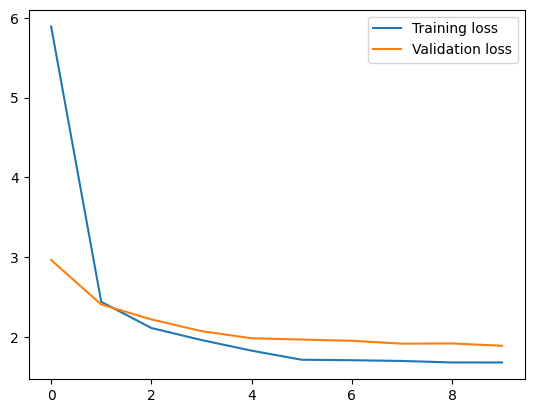

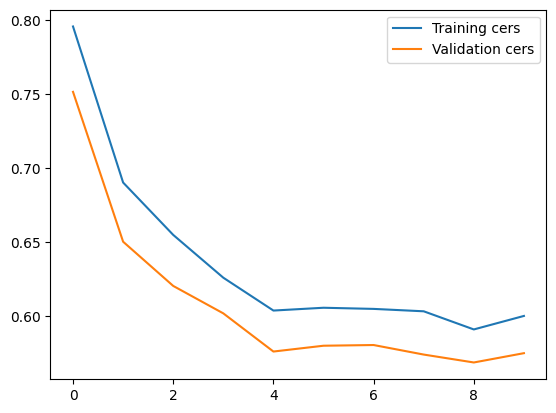

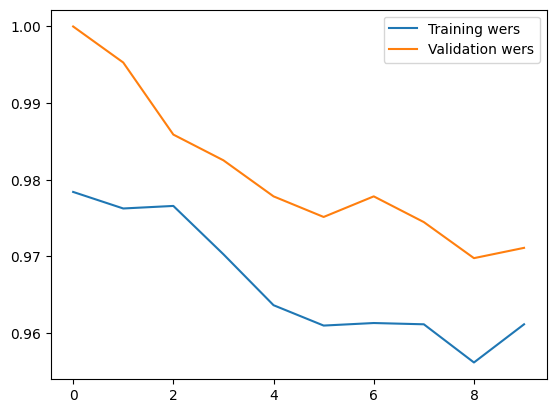

In [ ]:
optimizer = torch.optim.Adam(MyModel.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Adjust lr every step_size epoch

train_losses = []
val_losses = []
train_cers = []
val_cers = []
train_wers = []
val_wers = []

best_val_loss = float('inf')
num_epochs = 10

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(MyModel, train_loader, optimizer, ctc_loss, device)
    val_loss = validate(MyModel, val_loader, ctc_loss, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    train_preds, train_targs = calculate_predictions(MyModel, train_loader, device, decoder, tokenizer)
    val_preds, val_targs = calculate_predictions(MyModel, val_loader, device, decoder, tokenizer)

    #cer
    train_cer = compute_cer(train_targs, train_preds)
    val_cer = compute_cer(val_targs, val_preds)
    train_cers.append(train_cer)
    val_cers.append(val_cer)

    #wer
    train_wer = wer(train_targs, train_preds)
    val_wer = wer(val_targs, val_preds)
    train_wers.append(train_wer)
    val_wers.append(val_wer)

    for param_group in optimizer.param_groups:
      print('lr:', param_group['lr'])

    # update learning rate
    scheduler.step()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(MyModel.state_dict(), 'best_model_before_finetune_nov27_base.pth')

    print(f'Epoch {epoch}, Training loss: {train_loss}, Validation loss: {val_loss}')
    print(f'Training CER: {train_cer}, Validation CER: {val_cer}')
    print(f'Training WER: {train_wer}, Validation WER: {val_wer}')

plt.figure()
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_cers, label='Training cers')
plt.plot(val_cers, label='Validation cers')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_wers, label='Training wers')
plt.plot(val_wers, label='Validation wers')
plt.legend()
plt.show()

lr: 0.0001
Epoch 1, Training loss: 2.6073421362778553, Validation loss: 1.315763757779048
Training CER: 0.36656346749226004, Validation CER: 0.3916601101494886
lr: 0.0001
Epoch 2, Training loss: 1.325385580531699, Validation loss: 1.0911694719241216
Training CER: 0.26505417956656346, Validation CER: 0.3177025963808025
lr: 0.0001
Epoch 3, Training loss: 1.1857627756018148, Validation loss: 1.054557387645428
Training CER: 0.22321981424148607, Validation CER: 0.2835562549173879
lr: 0.0001
Epoch 4, Training loss: 1.6397526805206455, Validation loss: 1.0193813213935266
Training CER: 0.21033281733746131, Validation CER: 0.27143981117230526
lr: 0.0001
Epoch 5, Training loss: 0.6153631547657992, Validation loss: 0.8158148802243747
Training CER: 0.14125386996904024, Validation CER: 0.22879622344610542
lr: 0.0001
Epoch 6, Training loss: 0.4574639810075005, Validation loss: 0.7988316187491784
Training CER: 0.115015479876161, Validation CER: 0.2179386309992132
lr: 0.0001
Epoch 7, Training loss: 0.

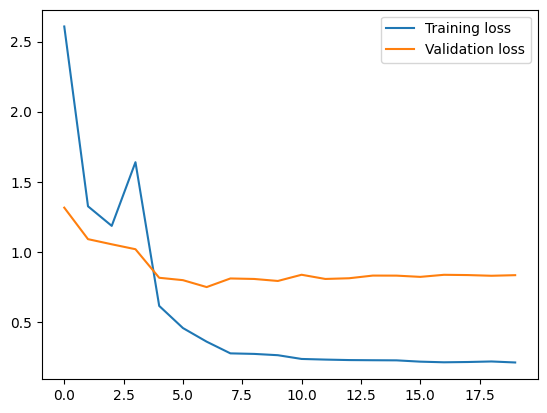

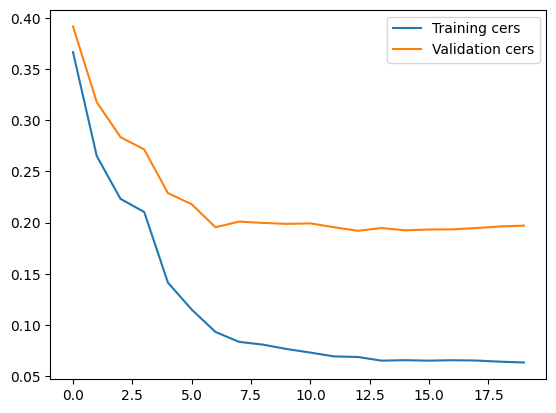

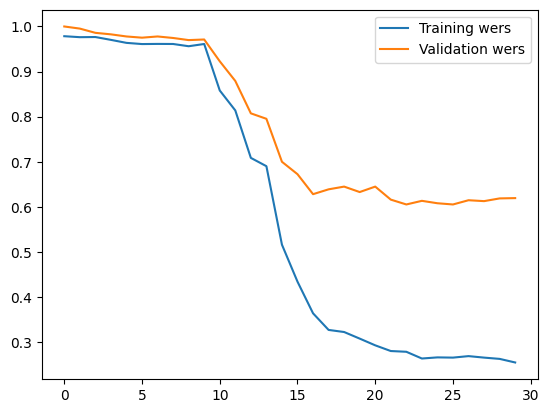

In [ ]:
optimizer = torch.optim.Adam(MyModel.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

for param in MyModel.parameters():
  param.requires_grad = True

train_losses = []
val_losses = []
train_cers = []
val_cers = []

best_val_loss = float('inf')
num_epochs = 20

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(MyModel, train_loader, optimizer, ctc_loss, device)
    val_loss = validate(MyModel, val_loader, ctc_loss, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    train_preds, train_targs = calculate_predictions(MyModel, train_loader, device, decoder, tokenizer)
    val_preds, val_targs = calculate_predictions(MyModel, val_loader, device, decoder, tokenizer)

    #cer
    train_cer = compute_cer(train_targs, train_preds)
    val_cer = compute_cer(val_targs, val_preds)
    train_cers.append(train_cer)
    val_cers.append(val_cer)

    #wer
    train_wer = wer(train_targs, train_preds)
    val_wer = wer(val_targs, val_preds)
    train_wers.append(train_wer)
    val_wers.append(val_wer)

    for param_group in optimizer.param_groups:
      print('lr:', param_group['lr'])

    # update learning rate
    scheduler.step()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(MyModel.state_dict(), 'best_model_after_finetune_nov27_base.pth')

    print(f'Epoch {epoch}, Training loss: {train_loss}, Validation loss: {val_loss}')
    print(f'Training CER: {train_cer}, Validation CER: {val_cer}')

plt.figure()
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_cers, label='Training cers')
plt.plot(val_cers, label='Validation cers')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_wers, label='Training wers')
plt.plot(val_wers, label='Validation wers')
plt.legend()
plt.show()

In [ ]:
print(min(train_losses))
print(min(val_losses))
print(min(train_cers))
print(min(val_cers))
print(min(train_wers))
print(min(val_wers))

0.21195550280795108
0.749499268256701
0.06327399380804953
0.1919748229740362
0.2545243234268637
0.6051040967092008


# Test

In [ ]:
MyModel = MyWav2Vec(num_classes=len(tokens))

# Load the state dictionary
model_path = '/content/drive/MyDrive/best_model_after_finetune_nov27_base.pth'
#MyModel.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
MyModel.load_state_dict(torch.load(model_path))
# Set the model to evaluation mode
MyModel.eval()

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960.pth
100%|██████████| 360M/360M [00:01<00:00, 218MB/s]


MyWav2Vec(
  (pretrained_model): Wav2Vec2Model(
    (feature_extractor): FeatureExtractor(
      (conv_layers): ModuleList(
        (0): ConvLayerBlock(
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        )
        (1-4): 4 x ConvLayerBlock(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        )
        (5-6): 2 x ConvLayerBlock(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        )
      )
    )
    (encoder): Encoder(
      (feature_projection): FeatureProjection(
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (projection): Linear(in_features=512, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (pos_conv_embed): ConvolutionalPositionalEmbedding(
          (conv): ParametrizedConv1d(
            768, 768,

In [ ]:
def test(model, dataloader_test, ctc_loss, device):
  model.eval()
  loss_test = 0.0
  total_samples = 0

  with torch.no_grad():
    for inputs, targets, target_lengths in dataloader_test:
      batch_size = inputs.size(0)
      total_samples += batch_size

      inputs = inputs.to(device=device)
      targets = targets.to(device=device)

      logits = model(inputs)
      logits = logits.permute(1, 0, 2)
      log_probs = nn.functional.log_softmax(logits, dim=-1)

      input_lengths = torch.full(size=(log_probs.shape[1],), fill_value=log_probs.shape[0], dtype=torch.int32, device=device)

      loss = ctc_loss(log_probs, targets, input_lengths, target_lengths)
      loss_test += loss.item() * batch_size

  avg_loss_test = loss_test / total_samples
  return avg_loss_test


In [ ]:
test_loss = test(MyModel.to(device=device), test_loader, ctc_loss, device)
test_preds, test_targs = calculate_predictions(MyModel, test_loader, device, decoder, tokenizer)
test_cer = compute_cer(test_targs, test_preds)
test_wer = wer(test_targs, test_preds)

print(f'Testing loss: {test_loss}')
print(f'Testing CER: {test_cer}')
print(f'Testing WER: {test_wer}')

Testing loss: 0.7053213272514928
Testing CER: 0.203125
Testing WER: 0.6316326530612245


# Model prediction on real data

In [ ]:
#Test
clips_list = ['common_voice_sr_27636603.mp3', 'common_voice_sr_27636658.mp3', 'common_voice_sr_27636711.mp3', 'common_voice_sr_27636678.mp3', 'common_voice_sr_27636625.mp3', 'common_voice_sr_27636632.mp3']
waveform_test_list = []
for clip in clips_list:
  waveform_test, sample_rate = torchaudio.load("drive/MyDrive/cv-corpus-11.0-2022-09-21-sr/cv-corpus-11.0-2022-09-21/sr/clips/" + clip)
  waveform_test = torchaudio.functional.resample(waveform_test, sample_rate, 16000)
  waveform_test_list.append(waveform_test)
  display(Audio(waveform_test.numpy(), rate=16000))

In [ ]:
device = 'cpu'
MyModel.eval().to(device=device)
# Predikcija
with torch.no_grad():
  for waveform_test in waveform_test_list:
    waveform_test = waveform_test.to(device=device)
    with torch.inference_mode():
        emission = MyModel(waveform_test)

    # print(emission.shape)
    # print(emission[0].shape)
    decoder = GreedyCTCDecoder(tokens)
    transcript = decoder(emission[0])
    print(transcript)

па и не може
шта је нема
садаенањихред
нато пита је дешкодгорите
плави су напоко личелина сева
то ври св ихна лаегала наче


In [ ]:
#TRENING
clips_list = ['common_voice_sr_26981130.mp3', 'common_voice_sr_26981131.mp3', 'common_voice_sr_26981409.mp3', 'common_voice_sr_26982156.mp3']
waveform_train_list = []
for clip in clips_list:
  waveform_test, sample_rate = torchaudio.load("drive/MyDrive/cv-corpus-11.0-2022-09-21-sr/cv-corpus-11.0-2022-09-21/sr/clips/" + clip)
  waveform_test = torchaudio.functional.resample(waveform_test, sample_rate, 16000)
  waveform_train_list.append(waveform_test)
  display(Audio(waveform_test.numpy(), rate=16000))

#to sve dokazuje, a ne moze, Данас је то објекат за понос, Било је време за акцију

In [ ]:
device = 'cpu'
MyModel.eval().to(device=device)
# Predikcija
with torch.no_grad():
  for waveform_test in waveform_train_list:
    waveform_test = waveform_test.to(device=device)
    with torch.inference_mode():
        emission = MyModel(waveform_test)

    # print(emission.shape)
    # print(emission[0].shape)
    decoder = GreedyCTCDecoder(tokens)
    transcript = decoder(emission[0])
    print(transcript)

то сведоказу је
а не може
дана си то обекадза понс
било је време закци


# Plan for further improvement of the model



1. drugi vocab - koji sadrzi delove reci kao vocab a ne samo slova !
2. jezicki model !
3. drugi nacin dekodovanja izlaza iz modela - nije pomoglo
4. dodavanje vise slojeva a ne samo 1, takodje i dropout za regularizaciju - nije pomoglo
5. uklanjanje suma iz audio zapisa pre treninga
6. postepeno otkljucavanje slojeva ili da ne otkljucam sve slojeve
7. neki drugi optimizer npr SGD sa momentumom ili Adagrad
